## Learning of two visual orientations using spiking neural networks

In [8]:
import numpy as np
import torch
import torch.nn as nn
from spikingjelly.activation_based import neuron, encoding
from utils.image_processing import processSingleImage
import matplotlib.pyplot as plt
from utils.plasticity import STDPLearner
import cv2

In [9]:
def dummy_image_processing(img):
    # Open CV is kinda shit ngl
    img = img / 255.
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j] != 1 or 0:
                if img[i][j] > 0.1:
                    img[i][j] = 1
                else:
                    img[i][j] = 0
    return img

## Network Architecture

In [46]:
class VPR(nn.Module):
    def __init__(self, tau, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.layer = nn.Sequential(
            nn.Flatten(start_dim=0, end_dim=-1),
            nn.Linear(28 * 28, 2, bias=False),
            neuron.LIFNode(tau=2., v_threshold=0.2)
        )

    def forward(self, x: torch.Tensor) -> nn.Sequential:
        return self.layer(x)

## Define Learning functions and parameters

In [47]:
def f_pre(x):
    return torch.clamp(x, -1, 1.)

def f_post(x):
    return torch.clamp(x, -1, 1.)

start_epoch = 0
epoch = 200
tau_pre = 5.
tau_post = 5.
lr = 0.001
T = 100
w_min, w_max = -1., 1.

N_out = 2
N_in = 784

## Instance of the Network

In [48]:
net = VPR(tau=2.)
encoder = encoding.PoissonEncoder() # Poison encoder for spike train creation using pixel intensity
learner = STDPLearner(synapse=net.layer[1], tau_pre=tau_pre, tau_post=tau_post,learning_rate=lr, f_post=f_post, f_pre=f_pre)

## Read Image from the Nordland dataset

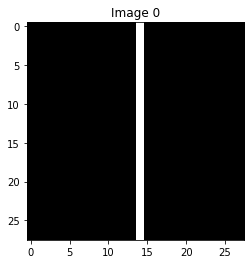

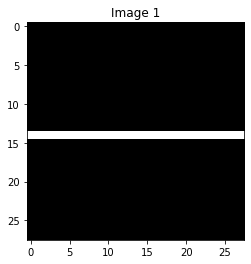

In [49]:
images = []
imgPaths = []
imgPaths.append("../Dummy_Inputs/dummy_inputs/1.jpg")
imgPaths.append("../Dummy_Inputs/dummy_inputs/14.jpg")

for i in range(len(imgPaths)):
    img = cv2.imread(imgPaths[i], cv2.IMREAD_GRAYSCALE)
    img = dummy_image_processing(img)
    images.append(img)
for i in range(len(images)):
    plt.figure()
    plt.imshow(images[i], cmap="gray")
    plt.title("Image "+str(i))

In [50]:
for i in range(len(images)):
    images[i] = torch.from_numpy(images[i])

In [51]:

# For plotting 
in_spike = []
out_spike = []
trace_pre = []
trace_post = np.zeros((len(images),N_out,T))
weights = np.zeros((len(images),N_out,T))
index = 0

for img in images:
    for t in range(T):
        encoded_img = encoder(img)
    
        # Pre and post spikes, after forward
        in_spike.append(encoded_img[14][14].numpy())
        out_spike.append(net(encoded_img.float()).detach().numpy())
    
        # Torch Input processing for STDP 
        s_pre = torch.from_numpy(np.expand_dims(net.layer[0](encoded_img.float()), axis=0))
        s_post = torch.from_numpy(np.expand_dims(out_spike[t], axis=0))
        
        # # Forced Inhibition 
        # for spike in range(len(out_spike[index])):
        #     if out_spike[index][spike] == 1:
        #         print("Spike on neuron #", spike+1)
        #         out_spike = np.zeros(len(out_spike))
        #         out_spike[spike] = 1
        #         break

        # STDP step
        learner.single_step(s_pre, s_post)
    
        # Plotting 
        trace_pre.append(learner.trace_pre[0][0].numpy())
        for i in range(N_out):
            weights[index][i][t] = net.layer[1].weight[i][0].detach().numpy()
            trace_post[index][i][t] = learner.trace_post[0][i].numpy()


(0.0, 100.0)

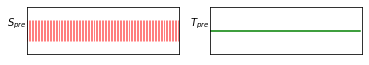

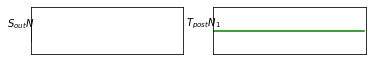

In [52]:
t = np.arange(0, T)
out_spike = np.array(out_spike)

neuron1 = out_spike[:,0]
neuron2 = out_spike[:,1]

plt.figure()
plt.subplot(4,2,1)
plt.eventplot(t * in_spike[0:T], lineoffsets=0, linewidths=0.5, colors='r')
plt.yticks([])
plt.ylabel('$S_{pre}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.subplot(4,2,2)
plt.plot(t, trace_pre[0:T], c="green")
plt.yticks([])
plt.ylabel('$T_{pre}$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.figure()
plt.subplot(4,2,3)
plt.eventplot(t * neuron2[0:T], lineoffsets=0, linewidths=0.5)
plt.yticks([])
plt.ylabel('$S_{out} N$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)

plt.subplot(4,2,4)
plt.plot(t, trace_post[0][0], c="green")
plt.yticks([])
plt.ylabel('$T_{post} N_1$', rotation=0, labelpad=10)
plt.xticks([])
plt.xlim(0, T)